# Using Iris to access data from US-IOOS models
Here we demonstrate accessing a specified variable from a number of different CF compliant models via OPeNDAP.  Iris takes advantage of the CF conventions to standardize the access to time, lon, lat and depth information from the models.  

You can run this notebook using the [IOOS conda environment](https://github.com/ioos/conda-recipes/wiki)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
import iris
import cmocean

First define some functions:

In [2]:
def find_timevar(cube):
    """Return the variable attached to
    time axis and rename it to time."""
    try:
        cube.coord(axis='T').rename('time')
        print('Renaming {} to time'.format(cube.coord('time').var_name))
    except:
        pass
    timevar = cube.coord('time')
    return timevar

In [3]:
def time_near(cube, start):
    """Return the nearest time to `start`.
    TODO: Adapt to the new slice syntax"""
    timevar = find_timevar(cube)
    try:
        time1 = timevar.units.date2num(start)
        itime = timevar.nearest_neighbour_index(time1)
    except IndexError:
        itime = -1
    return timevar.points[itime]

In [4]:
def var_lev_date(url=None,var=None,mytime=None,lev=0,subsample=1):
    time0= time.time()
#    cube = iris.load_cube(url,iris.Constraint(name=var.strip()))[0]
    cube = iris.load_cube(url,var)
#    cube = iris.load(url,var)[0]
#    print cube.coord('time')

    try:
        cube.coord(axis='T').rename('time')
    except:
        pass
    slice = cube.extract(iris.Constraint(time=time_near(cube,mytime)))
    slice = slice[lev,::subsample,::subsample]  
    print 'slice retrieved in %f seconds' % (time.time()-time0)
    return slice

In [5]:
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def make_map(projection=ccrs.PlateCarree(), figsize=(12,8)):
    fig, ax = plt.subplots(figsize=figsize,
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [6]:
def map_plot(c,model=None):
    cmap = cmocean.cm.temperature
#    cmap = 'jet'
    fig, ax = make_map()
    lat = c.coord(axis='Y').points
    lon = c.coord(axis='X').points
    time = c.coord('time')[0]

    cs = plt.pcolormesh(lon,lat,
                    np.ma.masked_invalid(c.data),
                    vmin = 4, vmax= 32.,
                    zorder=1, cmap=cmap)
    plt.colorbar()
    date=time.units.num2date(time.points)
    date_str=date[0].strftime('%Y-%m-%d %H:%M:%S %Z')
    plt.title('%s: %s: %s' % (model,c.long_name,date_str));
    _ = ax.coastlines('10m')

Specify a time here:

In [7]:
# use contraints to select nearest time
#mytime=dt.datetime(2008,7,28,12)  #specified time...
mytime=dt.datetime.utcnow()      # .... or now
print mytime

2015-12-16 15:41:41.875000


Specify a model OPeNDAP data endpoint, variable and level here:

C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\cf.py:1058: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'v' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\cf.py:1058: UserWarning: Ignoring formula terms variable u'zeta' referenced by data variable u'v' via variable u's_rho': Dimensions (u'time', u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\cf.py:1058: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'u' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_u', u'xi_u')
  warnings.warn(msg)
C:\Users\rsignell\AppD

slice retrieved in 10.579000 seconds


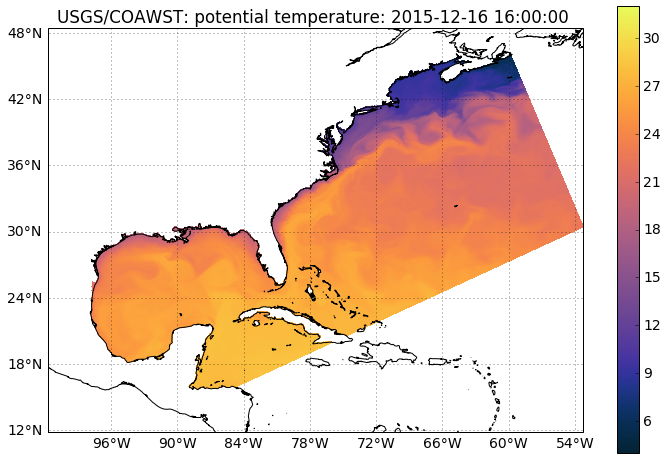

In [8]:
model = 'USGS/COAWST'
url = 'http://geoport-dev.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'
var = 'sea_water_potential_temperature'
lev = -1
icube = var_lev_date(url=url, var=var, mytime=mytime, lev=lev, subsample=1)
map_plot(icube, model=model)

slice retrieved in 3.950000 seconds


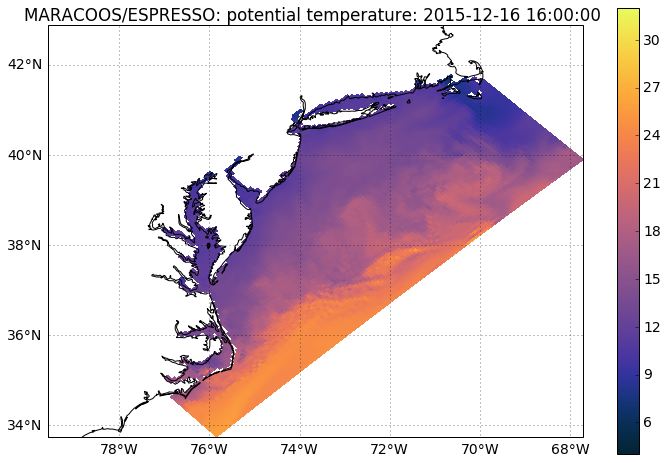

In [9]:
model='MARACOOS/ESPRESSO'
url='http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best'
var='sea_water_potential_temperature'
lev=-1
icube = var_lev_date(url=url,var=var, mytime=mytime, lev=lev)
map_plot(icube, model=model)

C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'chlorophyll' invalid units u'milligrams_chlorophyll meter-3'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'phytoplankton' invalid units u'millimole_nitrogen meter-3'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


slice retrieved in 1.734000 seconds


C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'NO3' invalid units u'millimole_N03 meter-3'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'zooplankton' invalid units u'millimole_nitrogen meter-3'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'NH4' invalid units u'millimole_NH4 meter-3'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


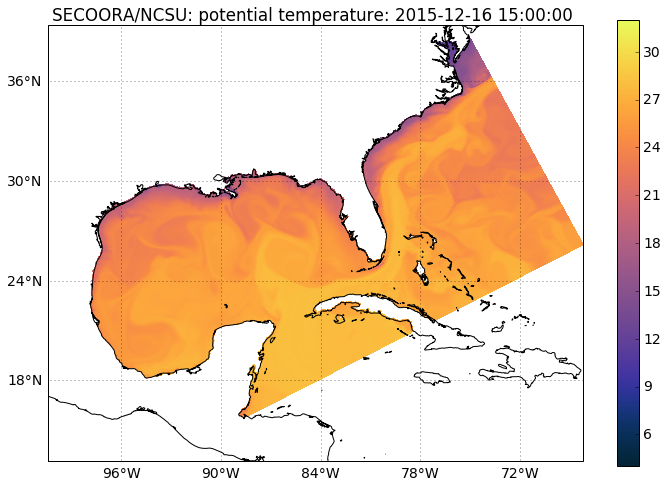

In [10]:
model='SECOORA/NCSU'
url='http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/sabgom/SABGOM_Forecast_Model_Run_Collection_best.ncd'
var='sea_water_potential_temperature'
lev=-1
icube = var_lev_date(url=url,var=var, mytime=mytime, lev=lev)
map_plot(icube, model=model)

slice retrieved in 3.994000 seconds


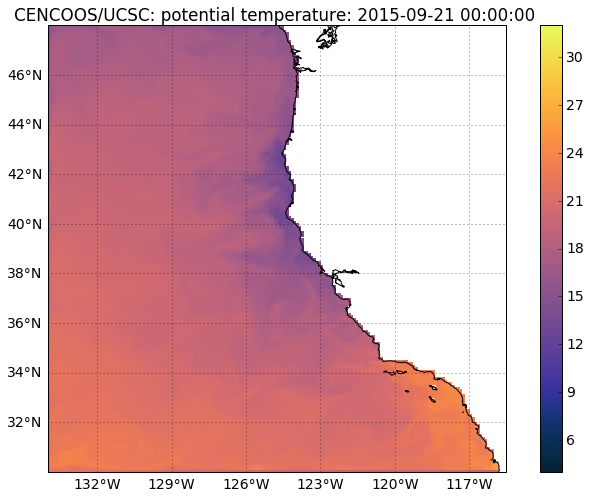

In [11]:
model='CENCOOS/UCSC'
url='http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsnrt/fmrc/CCSNRT_Aggregation_best.ncd'
var='potential temperature'
lev=-1
icube = var_lev_date(url=url,var=var, mytime=mytime, lev=lev)
map_plot(icube, model=model)

slice retrieved in 3.505000 seconds


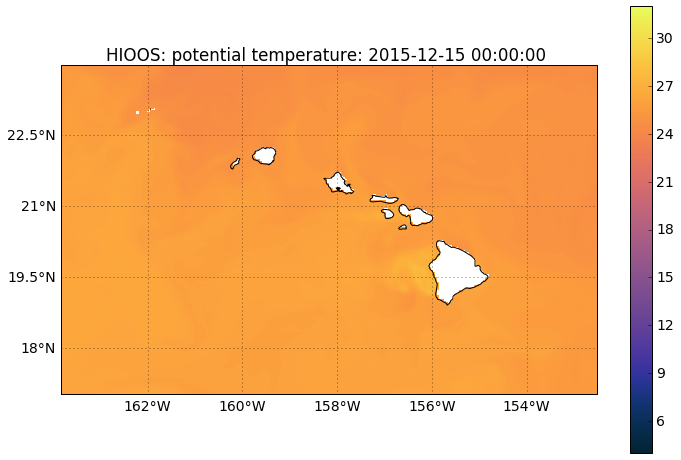

In [12]:
model='HIOOS'
url='http://oos.soest.hawaii.edu/thredds/dodsC/hioos/roms_assim/hiig/ROMS_Hawaii_Regional_Ocean_Model_Assimilation_best.ncd'
var='sea_water_potential_temperature'
lev=0
icube = var_lev_date(url=url,var=var, mytime=mytime, lev=lev)
map_plot(icube, model=model)


slice retrieved in 2.676000 seconds


C:\Users\rsignell\AppData\Local\Continuum\Anaconda2\envs\IOOS\lib\site-packages\iris\fileformats\_pyke_rules\compiled_krb\fc_rules_cf_fc.py:1304: UserWarning: Ignoring netCDF variable u'salinity' invalid units u'psu'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


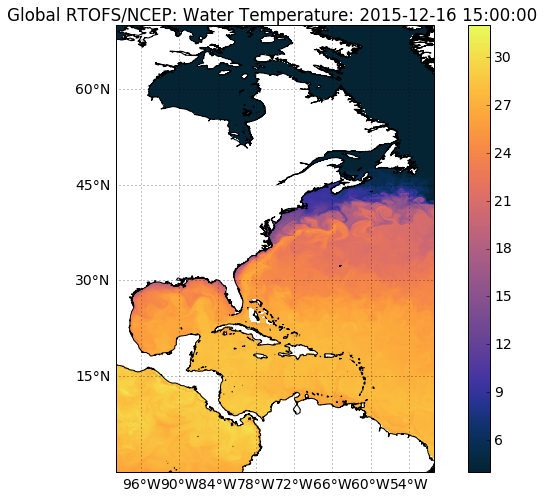

In [13]:
model='Global RTOFS/NCEP'
url='http://ecowatch.ncddc.noaa.gov/thredds/dodsC/hycom/hycom_reg1_agg/HYCOM_Region_1_Aggregation_best.ncd'
var='sea_water_temperature'  
lev=1
icube = var_lev_date(url=url,var=var, mytime=mytime, lev=lev, subsample=1)
map_plot(icube, model=model)

In [14]:
print icube

sea_water_temperature / (degC)      (latitude: 876; longitude: 626)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          depth: 2.0 meter
          forecast_reference_time: 2015-12-15 00:00:00
          time: 2015-12-16 15:00:00
     Attributes:
          Conventions: CF-1.4, _Coordinates
          NAVO_code: 15
          _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
          cdm_data_type: GRID
          classification_authority: not applicable
          classification_level: UNCLASSIFIED
          comment: ...
          contact: NAVO, NP31
          distribution_statement: Approved for public release. Distribution unlimited.
          downgrade_date: not applicable
          featureType: GRID
          field_type: instantaneous
          generating_model: Global HYCOM with OSU tides
          history: created on 20151214 ;
FMRC Best Dataset
